# COVSCO:

## Data Exploration

### The data

In [222]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# =============================================================================
# Imports #%%
# =============================================================================
#part| #%%
from datetime import datetime

import numpy as np
import pandas as pd
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.decomposition import FastICA
from sklearn.ensemble import StackingRegressor
import xgboost as xgb
from tpot import TPOTRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import tensorflow as tf 
from tensorflow.keras import callbacks
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from copy import copy
import joblib as joblib
import matplotlib.pyplot as plt

def max_normalize(x):
    return (x - x.min()) / (x.max() - x.min())

def mse(ground_truth, predictions):
    diff = (ground_truth - predictions)**2
    return diff.mean()

def mae(ground_truth, predictions):
    diff = abs(ground_truth - predictions)
    return diff.mean()

df = pd.read_csv("../data/train/all_data_merged/fr/Enriched_Covid_history_data.csv")
df = df.dropna()
df["all_day_bing_tiles_visited_relative_change"]=df["all_day_bing_tiles_visited_relative_change"].astype(float)
df["all_day_ratio_single_tile_users"]=df["all_day_ratio_single_tile_users"].astype(float)
df["time"]=pd.to_datetime(df["time"])
print(df)
columnstonormalize = ['pm25', 'no2','o3','pm10','co','pm257davg','no27davg','o37davg','co7davg', 'pm107davg','1MMaxpm25','1MMaxpm10','1MMaxo3','1MMaxno2','1MMaxco']
# for c in columnstonormalize:
#     df[c]=max_normalize(df[c])

featuresandtarget = ['idx', 'pm25', 'no2',\
'o3','pm10','co',\
    'pm257davg','no27davg',\
    'o37davg','co7davg', 'pm107davg',\
        "normpm25","normno2","normo3","normpm10","normco",
        'hospiprevday','covidpostestprevday','prevdaytotalcovidcasescumulated',\
            'all_day_bing_tiles_visited_relative_change','all_day_ratio_single_tile_users','vac1nb', 'vac2nb',\
                 'Insuffisance respiratoire chronique grave (ALD14)', \
                     'Insuffisance cardiaque grave, troubles du rythme graves, cardiopathies valvulaires graves, cardiopathies congénitales graves (ALD5)',\
                         'Smokers',\
                             "minority",\
                                  "Nb_susp_501Y_V1","Nb_susp_501Y_V2_3",\
                                      '1MMaxpm25','1MMaxpm10','1MMaxo3','1MMaxno2','1MMaxco',\
                                          'pm251Mavg','no21Mavg','o31Mavg','pm101Mavg','co1Mavg',\
                                             '1MMaxnormpm25','1MMaxnormno2','1MMaxnormo3','1MMaxnormpm10','1MMaxnormco',\
                                                 "normpm257davg","normno27davg","normo37davg","normpm107davg","normco7davg",\
                                                        "normpm251Mavg","normno21Mavg","normo31Mavg","normpm101Mavg","normco1Mavg",
                                                           'newhospi'\

                            ]
                                            
features = ['idx', 'pm25', 'no2',
'o3','pm10','co',\
    'pm257davg','no27davg',\
    'o37davg','co7davg', 'pm107davg',\
        "normpm25","normno2","normo3","normpm10","normco",
        'hospiprevday','covidpostestprevday','prevdaytotalcovidcasescumulated',\
            'all_day_bing_tiles_visited_relative_change','all_day_ratio_single_tile_users','vac1nb', 'vac2nb',\
                 'Insuffisance respiratoire chronique grave (ALD14)', \
                     'Insuffisance cardiaque grave, troubles du rythme graves, cardiopathies valvulaires graves, cardiopathies congénitales graves (ALD5)',\
                         'Smokers',\
                         "minority",\
                             "Nb_susp_501Y_V1","Nb_susp_501Y_V2_3",
                                 '1MMaxpm25','1MMaxpm10','1MMaxo3','1MMaxno2','1MMaxco',\
                                 'pm251Mavg','no21Mavg','o31Mavg','pm101Mavg','co1Mavg'
                            ]


              nom  numero       time  hospi  reanim  newhospi  newreanim  \
1             Ain     1.0 2020-05-14  137.0     8.0       4.0        0.0   
2             Ain     1.0 2020-05-15  135.0     7.0       4.0        0.0   
3             Ain     1.0 2020-05-16  134.0     6.0       1.0        0.0   
4             Ain     1.0 2020-05-17  133.0     6.0       1.0        0.0   
5             Ain     1.0 2020-05-18  132.0     6.0       1.0        0.0   
...           ...     ...        ...    ...     ...       ...        ...   
30680  Val-d'Oise    95.0 2021-03-27  659.0    79.0      43.0        7.0   
30681  Val-d'Oise    95.0 2021-03-28  667.0    81.0      38.0        7.0   
30682  Val-d'Oise    95.0 2021-03-29  680.0    76.0      44.0        4.0   
30683  Val-d'Oise    95.0 2021-03-30  688.0    75.0      88.0        5.0   
30684  Val-d'Oise    95.0 2021-03-31  698.0    77.0      83.0        7.0   

        deces  gueris  dep_num  ...  normco1Mavg  dep_y      jour_y   P_y  \
1        8

In [52]:
data = df[featuresandtarget]
start = df["time"].min()

# €df_ts = df.resample('W', how= 'max')
# €df_ts.plot(kind='bar', stacked=True)

### Ozone (O3) and the number of severe COVID19 cases leading to hospitalization

#### Departement 75: Paris region Ile de France

<AxesSubplot:>

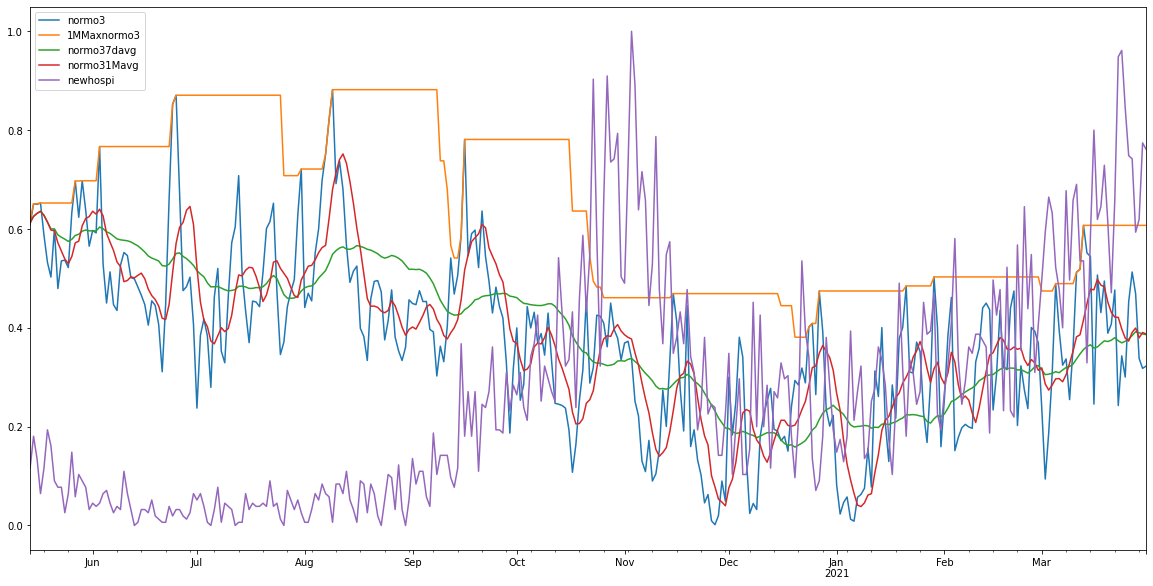

In [53]:
data = df[["numero","time","normpm25","normno2","normo3","normpm10","normco","1MMaxnormo3","normpm257davg","normno27davg","normo37davg","normpm107davg","normco7davg",\
            "normpm251Mavg","normno21Mavg","normo31Mavg","normpm101Mavg","normco1Mavg",'newhospi']]
data = data[data["numero"]==75][["normo3","1MMaxnormo3","normo37davg",\
            "normo31Mavg",'newhospi']]
data["newhospi"]=max_normalize(data["newhospi"])
idx = pd.date_range(df["time"].min(), periods= 322).tolist()
data.index = idx
data.plot.line(figsize = (20,10))

#### Departement 83: Var region PACA

<AxesSubplot:>

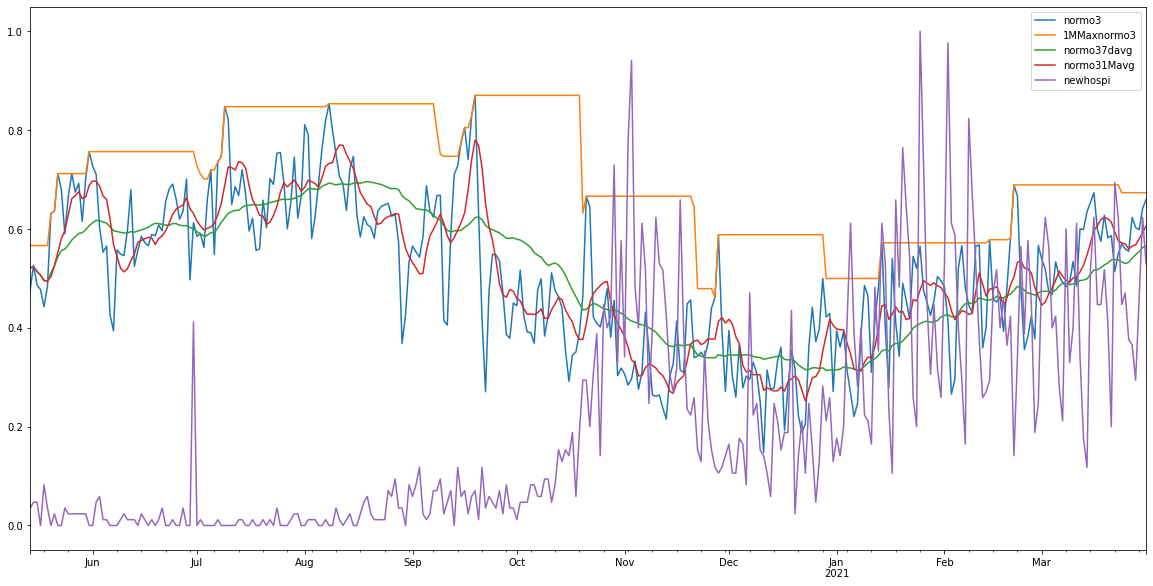

In [54]:
data = df[["numero","time","normpm25","normno2","normo3","normpm10","normco","1MMaxnormo3","normpm257davg","normno27davg","normo37davg","normpm107davg","normco7davg",\
            "normpm251Mavg","normno21Mavg","normo31Mavg","normpm101Mavg","normco1Mavg",'newhospi']]
data = data[data["numero"]==83][["normo3","1MMaxnormo3","normo37davg",\
            "normo31Mavg",'newhospi']]
data["newhospi"]=max_normalize(data["newhospi"])
idx = pd.date_range(df["time"].min(), periods= 322).tolist()
data.index = idx
data.plot.line(figsize = (20,10))

### Nitrogen dioxide (NO2) and the number of severe COVID19 cases leading to hospitalization

#### Departement 75: Paris region Ile de France

<AxesSubplot:>

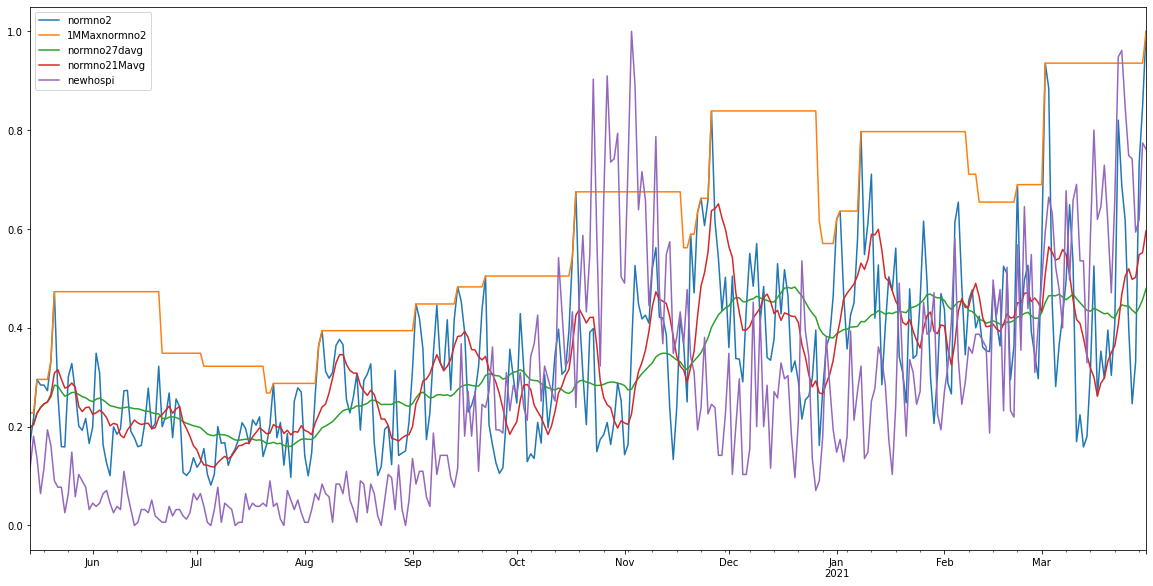

In [55]:
data = df[["numero","time","1MMaxnormno2","normpm25","normno2","normo3","normpm10","normco","1MMaxnormo3","normpm257davg","normno27davg","normo37davg","normpm107davg","normco7davg",\
            "normpm251Mavg","normno21Mavg","normo31Mavg","normpm101Mavg","normco1Mavg",'newhospi']]
data = data[data["numero"]==75][["normno2","1MMaxnormno2","normno27davg",\
            "normno21Mavg",'newhospi']]
data["newhospi"]=max_normalize(data["newhospi"])
idx = pd.date_range(df["time"].min(), periods= 322).tolist()
data.index = idx
data.plot.line(figsize = (20,10))

#### Departement 83: Var region PACA


<AxesSubplot:>

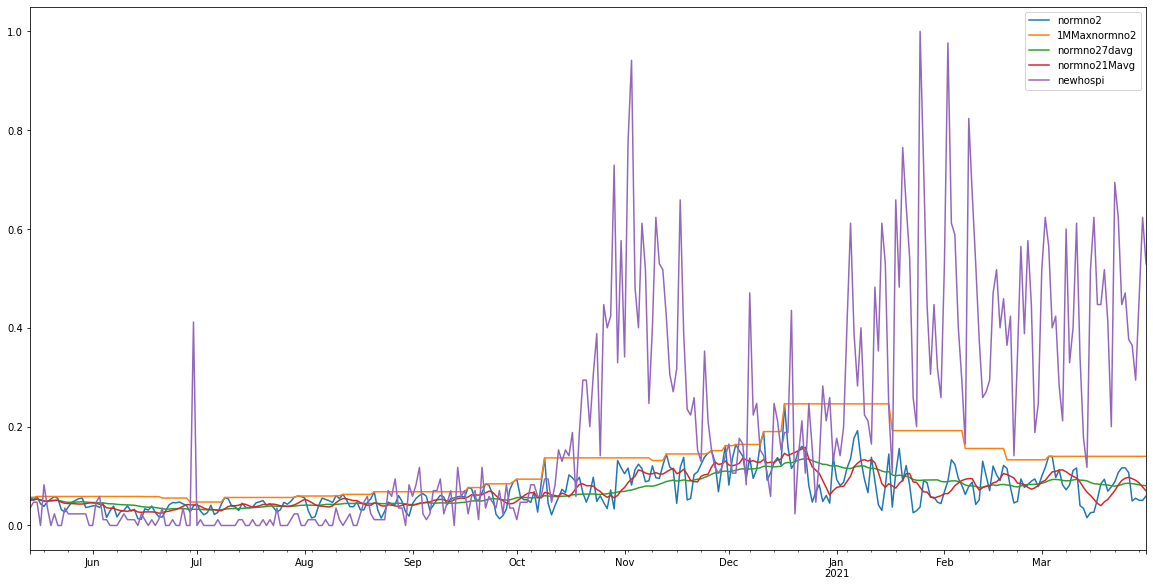

In [56]:
data = df[["numero","time","1MMaxnormno2","normpm25","normno2","normo3","normpm10","normco","1MMaxnormo3","normpm257davg","normno27davg","normo37davg","normpm107davg","normco7davg",\
            "normpm251Mavg","normno21Mavg","normo31Mavg","normpm101Mavg","normco1Mavg",'newhospi']]
data = data[data["numero"]==83][["normno2","1MMaxnormno2","normno27davg",\
            "normno21Mavg",'newhospi']]
data["newhospi"]=max_normalize(data["newhospi"])
idx = pd.date_range(df["time"].min(), periods= 322).tolist()
data.index = idx
data.plot.line(figsize = (20,10))

### PM2.5 and the number of severe COVID19 cases leading to hospitalization

#### Departement 75: Paris region Ile de France

<AxesSubplot:>

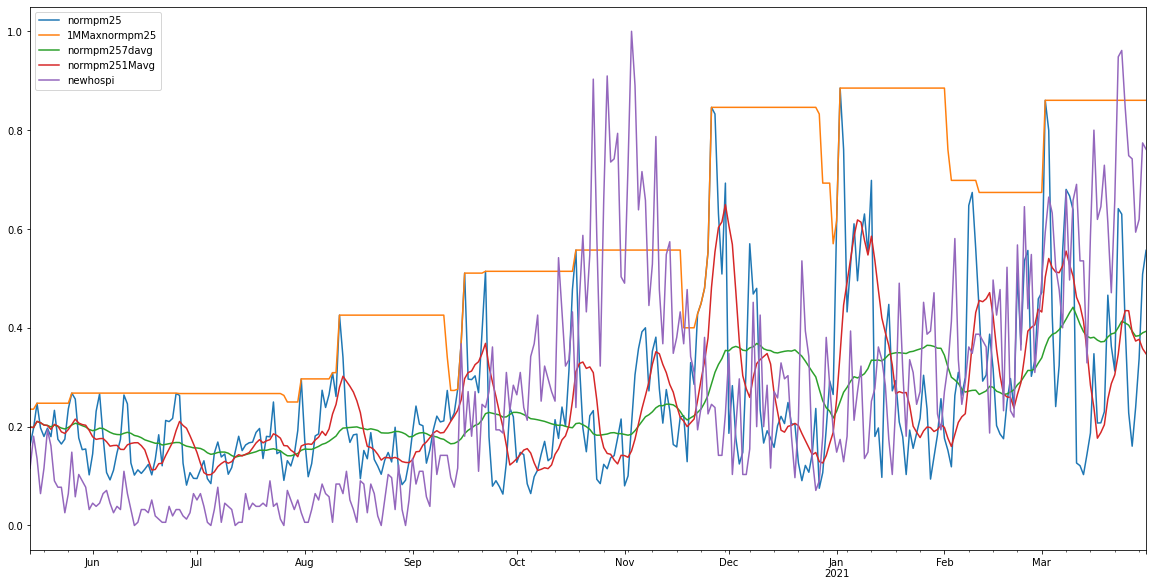

In [61]:
data = df[['1MMaxnormpm25',"numero","time","1MMaxnormno2","normpm25","normno2","normo3","normpm10","normco","1MMaxnormo3","normpm257davg","normno27davg","normo37davg","normpm107davg","normco7davg",\
            "normpm251Mavg","normno21Mavg","normo31Mavg","normpm101Mavg","normco1Mavg",'newhospi']]
data = data[data["numero"]==75][["normpm25","1MMaxnormpm25","normpm257davg",\
            "normpm251Mavg",'newhospi']]
data["newhospi"]=max_normalize(data["newhospi"])
idx = pd.date_range(df["time"].min(), periods= 322).tolist()
data.index = idx
data.plot.line(figsize = (20,10))


#### Departement 83: Var region PACA

<AxesSubplot:>

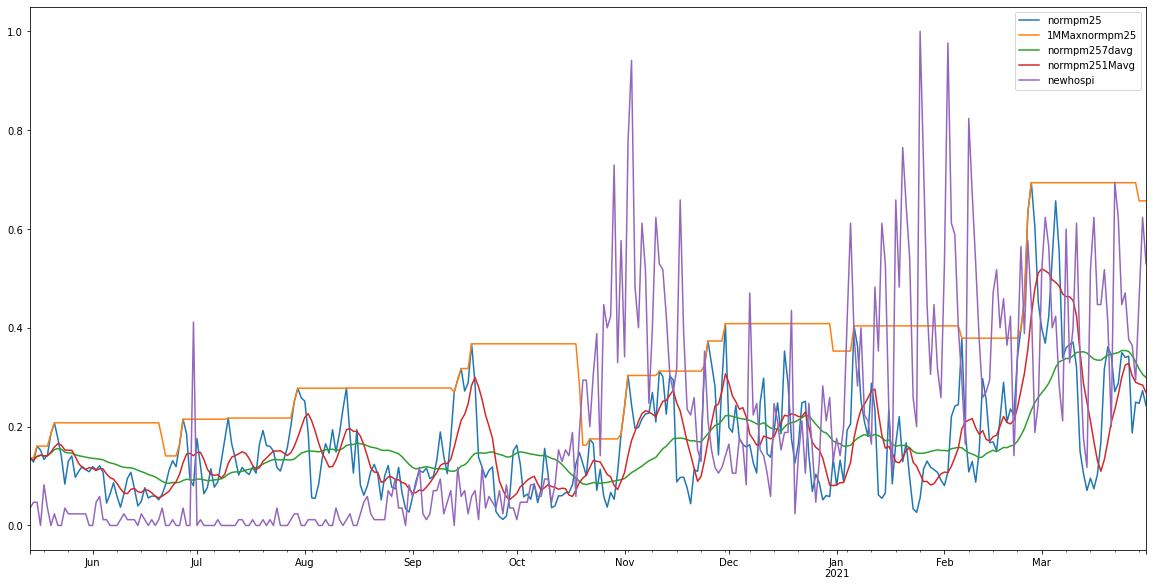

In [62]:
data = df[['1MMaxnormpm25',"numero","time","1MMaxnormno2","normpm25","normno2","normo3","normpm10","normco","1MMaxnormo3","normpm257davg","normno27davg","normo37davg","normpm107davg","normco7davg",\
            "normpm251Mavg","normno21Mavg","normo31Mavg","normpm101Mavg","normco1Mavg",'newhospi']]
data = data[data["numero"]==83][["normpm25","1MMaxnormpm25","normpm257davg",\
            "normpm251Mavg",'newhospi']]
data["newhospi"]=max_normalize(data["newhospi"])
idx = pd.date_range(df["time"].min(), periods= 322).tolist()
data.index = idx
data.plot.line(figsize = (20,10))

### CO and the number of severe COVID19 cases leading to hospitalization

#### Departement 75: Paris region Ile de France

<AxesSubplot:>

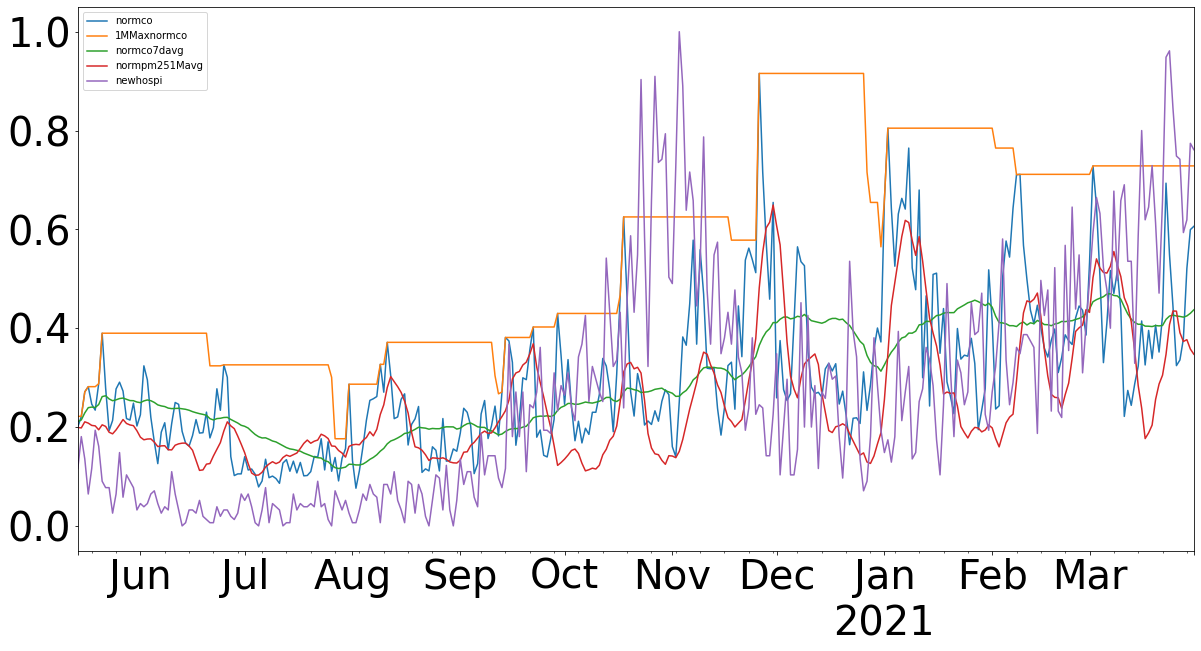

In [198]:
data = df[['1MMaxnormpm25',"numero","time","1MMaxnormco","normpm25","normno2","normo3","normpm10","normco","1MMaxnormo3","normpm257davg","normno27davg","normo37davg","normpm107davg","normco7davg",\
            "normpm251Mavg","normno21Mavg","normo31Mavg","normpm101Mavg","normco1Mavg",'newhospi']]
data = data[data["numero"]==75][["normco","1MMaxnormco","normco7davg",\
            "normpm251Mavg",'newhospi']]
data["newhospi"]=max_normalize(data["newhospi"])
idx = pd.date_range(df["time"].min(), periods= 322).tolist()
data.index = idx
data.plot.line(figsize = (20,10))

### The most polluted departements of France

In [237]:
datalist =[]
df2 = df.copy()
maximum_o3_pollution_level = df2[(df2["1MMaxo3"]==df2["1MMaxo3"].max())]
datalist.append((maximum_o3_pollution_level["nom"].unique()[0],\
                 maximum_o3_pollution_level["numero"].unique()[0],
                 maximum_o3_pollution_level["time"].min(),\
                 maximum_o3_pollution_level["1MMaxo3"].unique()[0],\
                 df2[df2["numero"]== maximum_o3_pollution_level["numero"].unique()[0]]['totalcovidcasescumulated'].max(),\
                 maximum_o3_pollution_level["idx"].unique()[0]))
alreadyseen = maximum_o3_pollution_level["nom"].unique()[0]
print(maximum_o3_pollution_level["numero"].unique())
counter = 1



while (counter !=95):
    counter += 1
    df2 = df2[df2["nom"]  != alreadyseen]
    maximum_o3_pollution_level = df2[(df2["1MMaxo3"]==df2["1MMaxo3"].max())]
    datalist.append((maximum_o3_pollution_level["nom"].unique()[0],\
                     maximum_o3_pollution_level["numero"].unique()[0],
                     maximum_o3_pollution_level["time"].min(),\
                     maximum_o3_pollution_level["1MMaxo3"].unique()[0],\
                     df2[df2["nom"]==maximum_o3_pollution_level["nom"].unique()[0]]['totalcovidcasescumulated'].max(),
                     maximum_o3_pollution_level["idx"].unique()[0]))
                     
    
    alreadyseen = maximum_o3_pollution_level["nom"].unique()[0]

dfexport = pd.DataFrame(datalist)
dfexport.columns=["Département","Numéro","Date of pollution peak","1MMaxo3",'totalcovidcasescumulated',"Population Index"]
print(dfexport)
dfexport.to_csv("../research/Pollution study by departement o3 1Y Max 1M-TM.csv", index = False)


[95.]
                Département  Numéro Date of pollution peak     1MMaxo3  \
0                Val-d'Oise    95.0             2020-08-09  122.889769   
1   Alpes-de-Haute-Provence     4.0             2020-08-08  119.833327   
2                 Haut-Rhin    68.0             2020-07-31  116.979563   
3                   Moselle    57.0             2020-08-10  115.873423   
4                       Ain     1.0             2020-09-18  114.506434   
..                      ...     ...                    ...         ...   
90     Pyrénées-Atlantiques    64.0             2020-08-06   94.093549   
91                     Gard    30.0             2020-05-20   93.974202   
92                     Cher    18.0             2020-07-13   93.921768   
93          Hautes-Pyrénées    65.0             2020-05-30   93.086194   
94                   Ariège     9.0             2020-05-29   90.297432   

    totalcovidcasescumulated  Population Index  
0                     237793         1215390.0  
1      

In [238]:

datalist =[]
df2 = df.copy()
maximum_pm25_pollution_level = df2[(df2["1MMaxpm25"]==df2["1MMaxpm25"].max())]
datalist.append((maximum_pm25_pollution_level["nom"].unique()[0],\
                 maximum_pm25_pollution_level["numero"].unique()[0],
                 maximum_pm25_pollution_level["time"].min(),\
                 maximum_pm25_pollution_level["1MMaxpm25"].unique()[0],\
                 df2[df2["numero"]== maximum_pm25_pollution_level["numero"].unique()[0]]['totalcovidcasescumulated'].max(),\
                 maximum_pm25_pollution_level["idx"].unique()[0]))
alreadyseen = maximum_pm25_pollution_level["nom"].unique()[0]
print(maximum_pm25_pollution_level["numero"].unique())
counter = 1



while (counter !=95):
    counter += 1
    df2 = df2[df2["nom"]  != alreadyseen]
    maximum_pm25_pollution_level = df2[(df2["1MMaxpm25"]==df2["1MMaxpm25"].max())]
    datalist.append((maximum_pm25_pollution_level["nom"].unique()[0],\
                     maximum_pm25_pollution_level["numero"].unique()[0],
                     maximum_pm25_pollution_level["time"].min(),\
                     maximum_pm25_pollution_level["1MMaxpm25"].unique()[0],\
                     df2[df2["nom"]==maximum_pm25_pollution_level["nom"].unique()[0]]['totalcovidcasescumulated'].max(),
                     maximum_pm25_pollution_level["idx"].unique()[0]))
                     
    
    alreadyseen = maximum_pm25_pollution_level["nom"].unique()[0]

dfexport = pd.DataFrame(datalist)
dfexport.columns=["Département","Numéro","Date of pollution peak","1MMaxpm25",'totalcovidcasescumulated',"Population Index"]
print(dfexport)
dfexport.to_csv("../research/Pollution study by departement pm25 1Y Max 1M-TM.csv", index = False)


[59.]
                Département  Numéro Date of pollution peak  1MMaxpm25  \
0                      Nord    59.0             2020-11-27  39.932960   
1                 Haut-Rhin    68.0             2021-02-24  37.243984   
2               Deux-Sèvres    79.0             2021-03-09  36.380767   
3                     Paris    75.0             2021-01-02  35.418335   
4                    Vienne    86.0             2021-03-09  34.895373   
..                      ...     ...                    ...        ...   
90          Alpes-Maritimes     6.0             2021-03-06  20.296409   
91                Côte-d'Or    21.0             2021-02-23  20.115372   
92                   Lozère    48.0             2021-03-04  19.935369   
93  Alpes-de-Haute-Provence     4.0             2021-02-23  19.765781   
94                  Ardèche     7.0             2021-03-04  19.407017   

    totalcovidcasescumulated  Population Index  
0                     477936         2605238.0  
1                  

In [239]:
datalist =[]
df2 = df.copy()
maximum_no2_pollution_level = df2[(df2["1MMaxno2"]==df2["1MMaxno2"].max())]
datalist.append((maximum_no2_pollution_level["nom"].unique()[0],\
                 maximum_no2_pollution_level["numero"].unique()[0],
                 maximum_no2_pollution_level["time"].min(),\
                 maximum_no2_pollution_level["1MMaxno2"].unique()[0],\
                 df2[df2["numero"]== maximum_no2_pollution_level["numero"].unique()[0]]['totalcovidcasescumulated'].max(),\
                 maximum_no2_pollution_level["idx"].unique()[0]))
alreadyseen = maximum_no2_pollution_level["nom"].unique()[0]
print(maximum_no2_pollution_level["numero"].unique())
counter = 1



while (counter !=95):
    counter += 1
    df2 = df2[df2["nom"]  != alreadyseen]
    maximum_no2_pollution_level = df2[(df2["1MMaxno2"]==df2["1MMaxno2"].max())]
    datalist.append((maximum_no2_pollution_level["nom"].unique()[0],\
                     maximum_no2_pollution_level["numero"].unique()[0],
                     maximum_no2_pollution_level["time"].min(),\
                     maximum_no2_pollution_level["1MMaxno2"].unique()[0],\
                     df2[df2["nom"]==maximum_no2_pollution_level["nom"].unique()[0]]['totalcovidcasescumulated'].max(),
                     maximum_no2_pollution_level["idx"].unique()[0]))
                     
    
    alreadyseen = maximum_no2_pollution_level["nom"].unique()[0]

dfexport = pd.DataFrame(datalist)
dfexport.columns=["Département","Numéro","Date of pollution peak","1MMaxno2",'totalcovidcasescumulated',"Population Index"]
print(dfexport)
dfexport.to_csv("../research/Pollution study by departement no2 1Y Max 1M-TM.csv", index = False)


[75.]
            Département  Numéro Date of pollution peak   1MMaxno2  \
0                 Paris    75.0             2021-03-31  67.312539   
1        Hauts-de-Seine    92.0             2021-03-02  64.475306   
2          Val-de-Marne    94.0             2021-01-08  53.384538   
3            Val-d'Oise    95.0             2021-03-02  51.599818   
4              Yvelines    78.0             2020-11-26  43.024886   
..                  ...     ...                    ...        ...   
90               Lozère    48.0             2021-01-07   7.727260   
91         Corse-du-Sud   201.0             2020-12-09   6.285247   
92               Ariège     9.0             2021-01-09   6.254226   
93  Pyrénées-Orientales    66.0             2021-01-09   6.071631   
94          Haute-Corse   202.0             2021-01-09   5.592579   

    totalcovidcasescumulated  Population Index  
0                     404122         2206488.0  
1                     266670         1601569.0  
2                 

In [240]:
datalist =[]
df2 = df.copy()
maximum_co_pollution_level = df2[(df2["1MMaxco"]==df2["1MMaxco"].max())]
datalist.append((maximum_co_pollution_level["nom"].unique()[0],\
                 maximum_co_pollution_level["numero"].unique()[0],
                 maximum_co_pollution_level["time"].min(),\
                 maximum_co_pollution_level["1MMaxco"].unique()[0],\
                 df2[df2["numero"]== maximum_co_pollution_level["numero"].unique()[0]]['totalcovidcasescumulated'].max(),\
                 maximum_co_pollution_level["idx"].unique()[0]))
alreadyseen = maximum_co_pollution_level["nom"].unique()[0]
print(maximum_co_pollution_level["numero"].unique())
counter = 1



while (counter !=95):
    counter += 1
    df2 = df2[df2["nom"]  != alreadyseen]
    maximum_co_pollution_level = df2[(df2["1MMaxco"]==df2["1MMaxco"].max())]
    datalist.append((maximum_co_pollution_level["nom"].unique()[0],\
                     maximum_co_pollution_level["numero"].unique()[0],
                     maximum_co_pollution_level["time"].min(),\
                     maximum_co_pollution_level["1MMaxco"].unique()[0],\
                     df2[df2["nom"]==maximum_co_pollution_level["nom"].unique()[0]]['totalcovidcasescumulated'].max(),
                     maximum_co_pollution_level["idx"].unique()[0]))
                     
    
    alreadyseen = maximum_co_pollution_level["nom"].unique()[0]

dfexport = pd.DataFrame(datalist)
dfexport.columns=["Département","Numéro","Date of pollution peak","1MMaxco",'totalcovidcasescumulated',"Population Index"]
print(dfexport)
dfexport.to_csv("../research/Pollution study by departement co 1Y Max 1M-TM.csv", index = False)



[92.]
            Département  Numéro Date of pollution peak     1MMaxco  \
0        Hauts-de-Seine    92.0             2020-11-26  476.783872   
1              Bas-Rhin    67.0             2020-11-10  442.772829   
2                 Paris    75.0             2020-11-26  442.031472   
3          Val-de-Marne    94.0             2021-01-02  400.354289   
4      Bouches-du-Rhône    13.0             2021-02-24  364.207868   
..                  ...     ...                    ...         ...   
90               Cantal    15.0             2021-01-06  204.699850   
91               Lozère    48.0             2021-01-07  202.482931   
92      Hautes-Pyrénées    65.0             2021-01-10  200.001928   
93               Ariège     9.0             2021-01-11  189.451920   
94  Pyrénées-Orientales    66.0             2021-03-06  182.390438   

    totalcovidcasescumulated  Population Index  
0                     266670         1601569.0  
1                     138675         1116658.0  
2     

In [245]:
datalist =[]
df2 = df.copy()
maximum_pm10_pollution_level = df2[(df2["1MMaxpm10"]==df2["1MMaxpm10"].max())]
datalist.append((maximum_pm10_pollution_level["nom"].unique()[0],\
                 maximum_pm10_pollution_level["numero"].unique()[0],
                 maximum_pm10_pollution_level["time"].min(),\
                 maximum_pm10_pollution_level["1MMaxpm10"].unique()[0],\
                 df2[df2["numero"]== maximum_pm10_pollution_level["numero"].unique()[0]]['totalcovidcasescumulated'].max(),\
                 maximum_pm10_pollution_level["idx"].unique()[0]))
alreadyseen = maximum_pm10_pollution_level["nom"].unique()[0]
print(maximum_pm10_pollution_level["numero"].unique())
pm10unter = 1



while (pm10unter !=95):
    pm10unter += 1
    df2 = df2[df2["nom"]  != alreadyseen]
    maximum_pm10_pollution_level = df2[(df2["1MMaxpm10"]==df2["1MMaxpm10"].max())]
    datalist.append((maximum_pm10_pollution_level["nom"].unique()[0],\
                     maximum_pm10_pollution_level["numero"].unique()[0],
                     maximum_pm10_pollution_level["time"].min(),\
                     maximum_pm10_pollution_level["1MMaxpm10"].unique()[0],\
                     df2[df2["nom"]==maximum_pm10_pollution_level["nom"].unique()[0]]['totalcovidcasescumulated'].max(),
                     maximum_pm10_pollution_level["idx"].unique()[0]))
                     
    
    alreadyseen = maximum_pm10_pollution_level["nom"].unique()[0]

dfexport = pd.DataFrame(datalist)
dfexport.columns=["Département","Numéro","Date of pollution peak","1MMaxpm10",'totalcovidcasescumulated',"Population Index"]
print(dfexport)
dfexport.to_csv("../research/Pollution study by departement pm10 1Y Max 1M-TM.csv", index = False)



[67.]
     Département  Numéro Date of pollution peak  1MMaxpm10  \
0       Bas-Rhin    67.0             2021-02-25  74.188288   
1      Haut-Rhin    68.0             2021-02-25  71.831104   
2   Corse-du-Sud   201.0             2021-02-06  70.996064   
3         Vosges    88.0             2021-02-25  70.504318   
4    Haute-Saône    70.0             2021-02-25  69.817902   
..           ...     ...                    ...        ...   
90       Mayenne    53.0             2021-03-03  40.262764   
91          Eure    27.0             2021-03-03  39.774691   
92      Calvados    14.0             2021-03-02  38.762629   
93        Sarthe    72.0             2021-03-03  36.942586   
94          Orne    61.0             2021-03-02  36.142811   

    totalcovidcasescumulated  Population Index  
0                     138675         1116658.0  
1                      79025          762607.0  
2                      11183          152730.0  
3                      41055          372016.0  
4   

## Training the model

In [202]:
X2=df[features]

y= df['newhospi']

# Hold-out
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.33)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.33)
print("\n")

# print(" Scikit Learn ExtratreesRegressor")
# ETregr = ExtraTreesRegressor()
# ETregr.fit(X_train2, y_train2)
# predET = ETregr.predict(X_test2).round(0)
# predETdf = pd.DataFrame(predET)
# predETdf.columns = ["prednewhospi"]
# featuresandtargetdf = X_test2.merge(y_test2, left_on = X_test2.index, right_on = y_test2.index)
# featuresandtargetdf["prednewhospi"]=predETdf["prednewhospi"].round(0)
# featuresandtargetdf.to_csv("../predictions/fr/new_hospi_predictions.csv", index = False)
# ETMSE = mse(y_test2, predET)
# ETMAE = mae(y_test2, predET)
# print("MSE")
# print(ETMSE)
# print("MAE")
# print(ETMAE)
# print("\n")


print("T-Pot exported current best pipeline")
# Average CV score on the training set was: -94.5319545151712
#exported_pipeline = ExtraTreesRegressor(bootstrap=False, max_features=0.7000000000000001, min_samples_leaf=1, min_samples_split=4, n_estimators=100)
exported_pipeline = GradientBoostingRegressor(alpha=0.85, learning_rate=0.1, loss="lad", max_depth=8, max_features=1.0, min_samples_leaf=5, min_samples_split=9, n_estimators=100, subsample=0.6500000000000001)

exported_pipeline.fit(X_train2, y_train2)
predictions = exported_pipeline.predict(X_test2)
TPOTMSE = mse(y_test2, predictions)
TPOTMAE = mae (y_test2, predictions)
print("MSE:")
print(TPOTMSE)
print("MAE:")
print(TPOTMAE)
print("\n")

exported_pipeline = GradientBoostingRegressor(alpha=0.85, learning_rate=0.1, loss="lad", max_depth=8, max_features=1.0, min_samples_leaf=5, min_samples_split=9, n_estimators=100, subsample=0.6500000000000001)

scores = cross_validate(exported_pipeline, X2, y, cv=5,
                        scoring=('neg_mean_squared_error',"neg_mean_absolute_error"),
                         return_train_score=True)
print(scores)
print("MSE:")
print(scores["test_neg_mean_squared_error"].mean())
print("MAE")
print(scores["test_neg_mean_absolute_error"].mean())



T-Pot exported current best pipeline
MSE:
49.379965117144714
MAE:
3.549285890228627


{'fit_time': array([44.6490314 , 43.858706  , 45.05859613, 45.09966588, 43.28667259]), 'score_time': array([0.03278375, 0.03353405, 0.03433108, 0.03335977, 0.03201985]), 'test_neg_mean_squared_error': array([-94.11949251, -78.83225151, -18.23985981, -16.88940783,
       -94.30448977]), 'train_neg_mean_squared_error': array([-32.22599203, -36.3931927 , -44.55435927, -46.32322545,
       -33.45767016]), 'test_neg_mean_absolute_error': array([-5.01420813, -4.54881579, -2.35917925, -2.3034336 , -5.38585998]), 'train_neg_mean_absolute_error': array([-2.69182282, -2.78320984, -3.17085717, -3.20584472, -2.67419383])}
MSE:
-60.47710028399084
MAE
-3.9222993487017463


Scikit Learn - GradientBoostingRegressor Feature importance report: [0.00865467 0.0055273  0.00556248 0.00578112 0.00630683 0.00591212
 0.01116804 0.01211506 0.0140648  0.02213806 0.01021512 0.00493352
 0.00608786 0.00540317 0.00542174 0.00723866 0.15980715 0.05630817
 0.45744286 0.02040705 0.03787047 0.00080284 0.00133321 0.0065513
 0.00594018 0.00361716 0.00715956 0.00213868 0.00145083 0.00789952
 0.00694463 0.01306922 0.00718748 0.00806277 0.00849647 0.01022997
 0.01264456 0.00837255 0.0197328 ]
                                                index  feature_importance
21                                             vac1nb            0.000803
22                                             vac2nb            0.001333
28                                  Nb_susp_501Y_V2_3            0.001451
27                                    Nb_susp_501Y_V1            0.002139
25                                            Smokers            0.003617
11                                           normpm2

<Figure size 900x600 with 0 Axes>

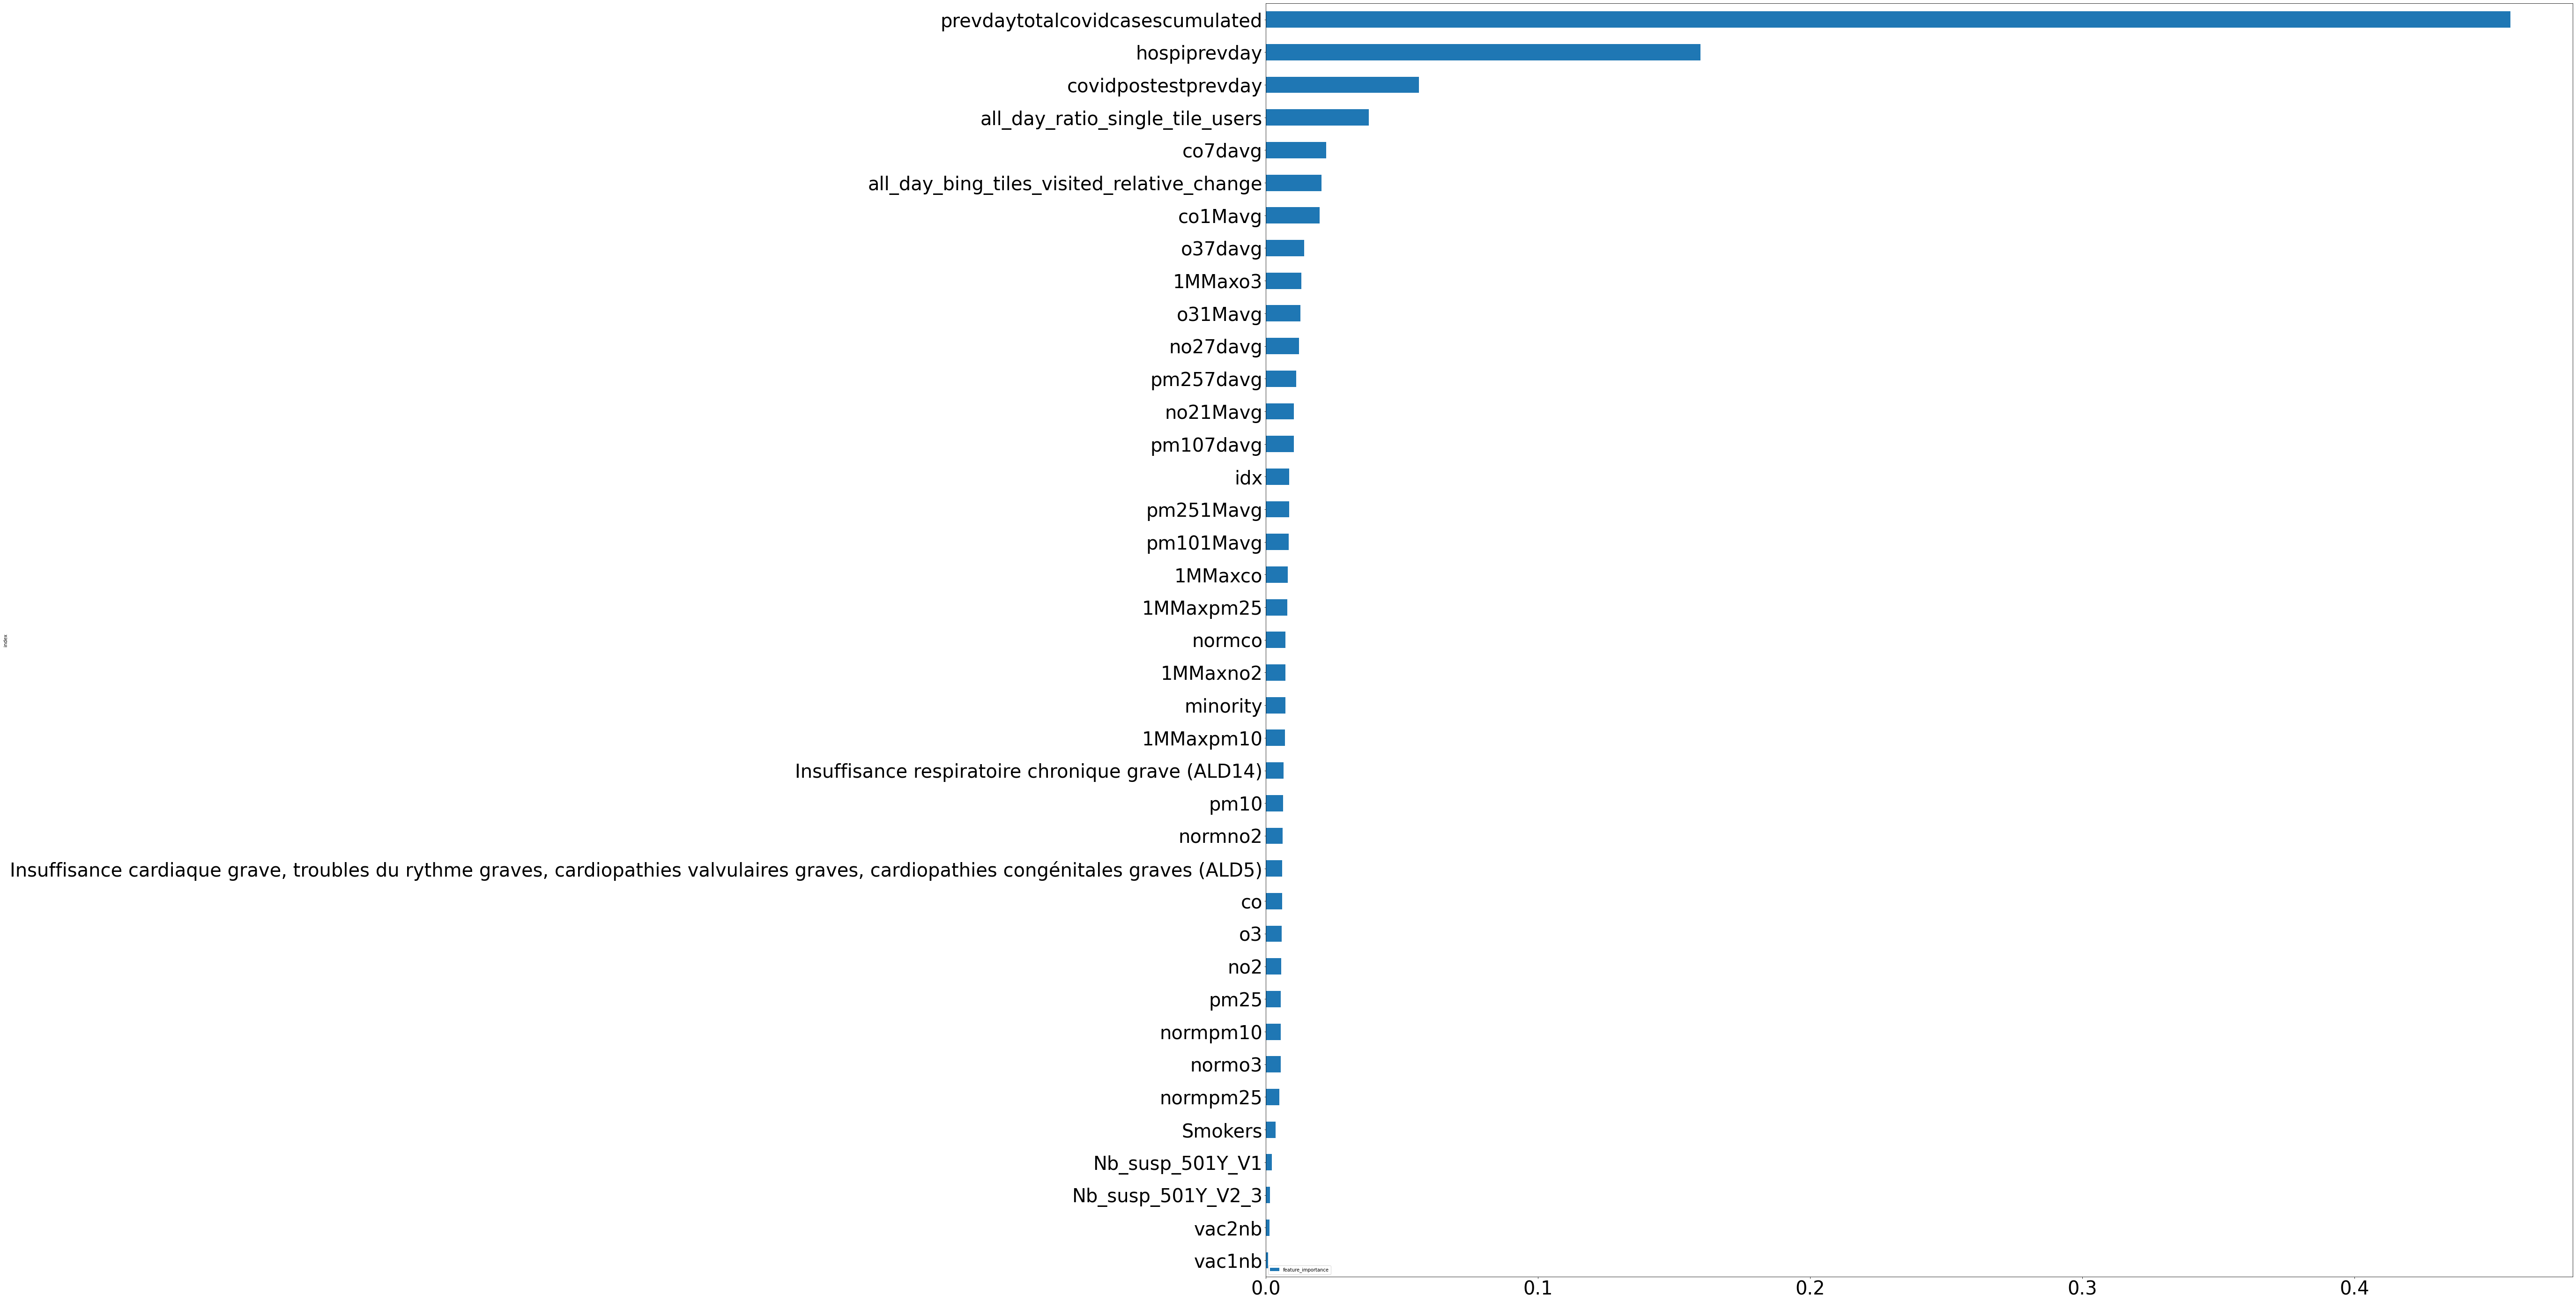

In [232]:
exported_pipeline = GradientBoostingRegressor(alpha=0.85, learning_rate=0.1, loss="lad", max_depth=8, max_features=1.0, min_samples_leaf=5, min_samples_split=9, n_estimators=100, subsample=0.6500000000000001)
exported_pipeline.fit(X2, y)
print("Scikit Learn - GradientBoostingRegressor Feature importance report:", exported_pipeline.feature_importances_)
FIlist = exported_pipeline.feature_importances_.tolist()
FIlistdf = pd.DataFrame(FIlist)
FIlistdf = FIlistdf.T
FIlistdf.columns = features
FIlistdf = FIlistdf.T.reset_index()
FIlistdf.columns = ["index","feature_importance"]
FIlistdf.sort_values(by = ["feature_importance"], inplace = True, ascending =True)
print(FIlistdf)
print("\n")
fig = plt.figure(dpi = 150)
plt.rc('xtick', labelsize=40) 
plt.rc('ytick', labelsize=40) 
FIlistdf.plot.barh(x="index", y="feature_importance",figsize = (50,50))
plt.show() 


In [165]:
# xgb_model = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
#              importance_type='gain', interaction_constraints='',
#              learning_rate=0.25, max_delta_step=0, max_depth=6,
#              min_child_weight=1, monotone_constraints='()',
#              n_estimators=100, n_jobs=1, num_parallel_tree=1, random_state=0,
#              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
#              tree_method='exact', validate_parameters=1, verbosity=None)
# scores = cross_validate(xgb_model, X3, y, cv=5,
#                         scoring=('neg_mean_squared_error',"neg_mean_absolute_error"),
#                          return_train_score=True)
# print(scores)

In [176]:
# model = ExtraTreesRegressor(n_estimators=70, n_jobs=4, min_samples_split=11,
#                             min_samples_leaf=1, max_features=0.94589)
                            
# gsc = GridSearchCV(
#     estimator=model,
#     param_grid={
#         #'n_estimators': range(69,71,1)
#         #'max_features': np.arange(float(0.944),float(0.946),0.0001),
#         #min_samples_leaf': range(1,10,1),
#         #'min_samples_split': range(10,12,1),
#     },
#     scoring=('neg_mean_squared_error'),
#     cv=5
# )

# grid_result = gsc.fit(X_train2, y_train2)

# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# print(grid_result.cv_results_)
# #for test_mean, train_mean, param in zip(
#        grid_result.cv_results_['mean_test_score'],
#        grid_result.cv_results_['mean_train_score'],
#        grid_result.cv_results_['params']):
#    print("Train: %f // Test : %f with: %r" % (train_mean, test_mean, param))
    
# model = ExtraTreesRegressor(**grid_result.best_params_)

model.fit(X_train_mini, y_train2)
predictions = model.predict(X_test_mini)
print("MSE")
print(mse(y_test2, predictions))
print("MAE")
print(mae(y_test2, predictions))






MSE
43.801929863159344
MAE
3.5710925027432143


Scikit Learn - Extra Trees Regressor Feature importance report:
                                                index  feature_importance
27                                  Nb_susp_501Y_V2_3            0.002173
1                                                pm25            0.002297
4                                                pm10            0.002307
11                                           normpm25            0.002407
14                                           normpm10            0.002461
36                                          pm101Mavg            0.002588
33                                          pm251Mavg            0.002654
34                                           no21Mavg            0.002840
21                                             vac2nb            0.002937
2                                                 no2            0.002986
3                                                  o3            0.003308
12                                            no

<Figure size 900x600 with 0 Axes>

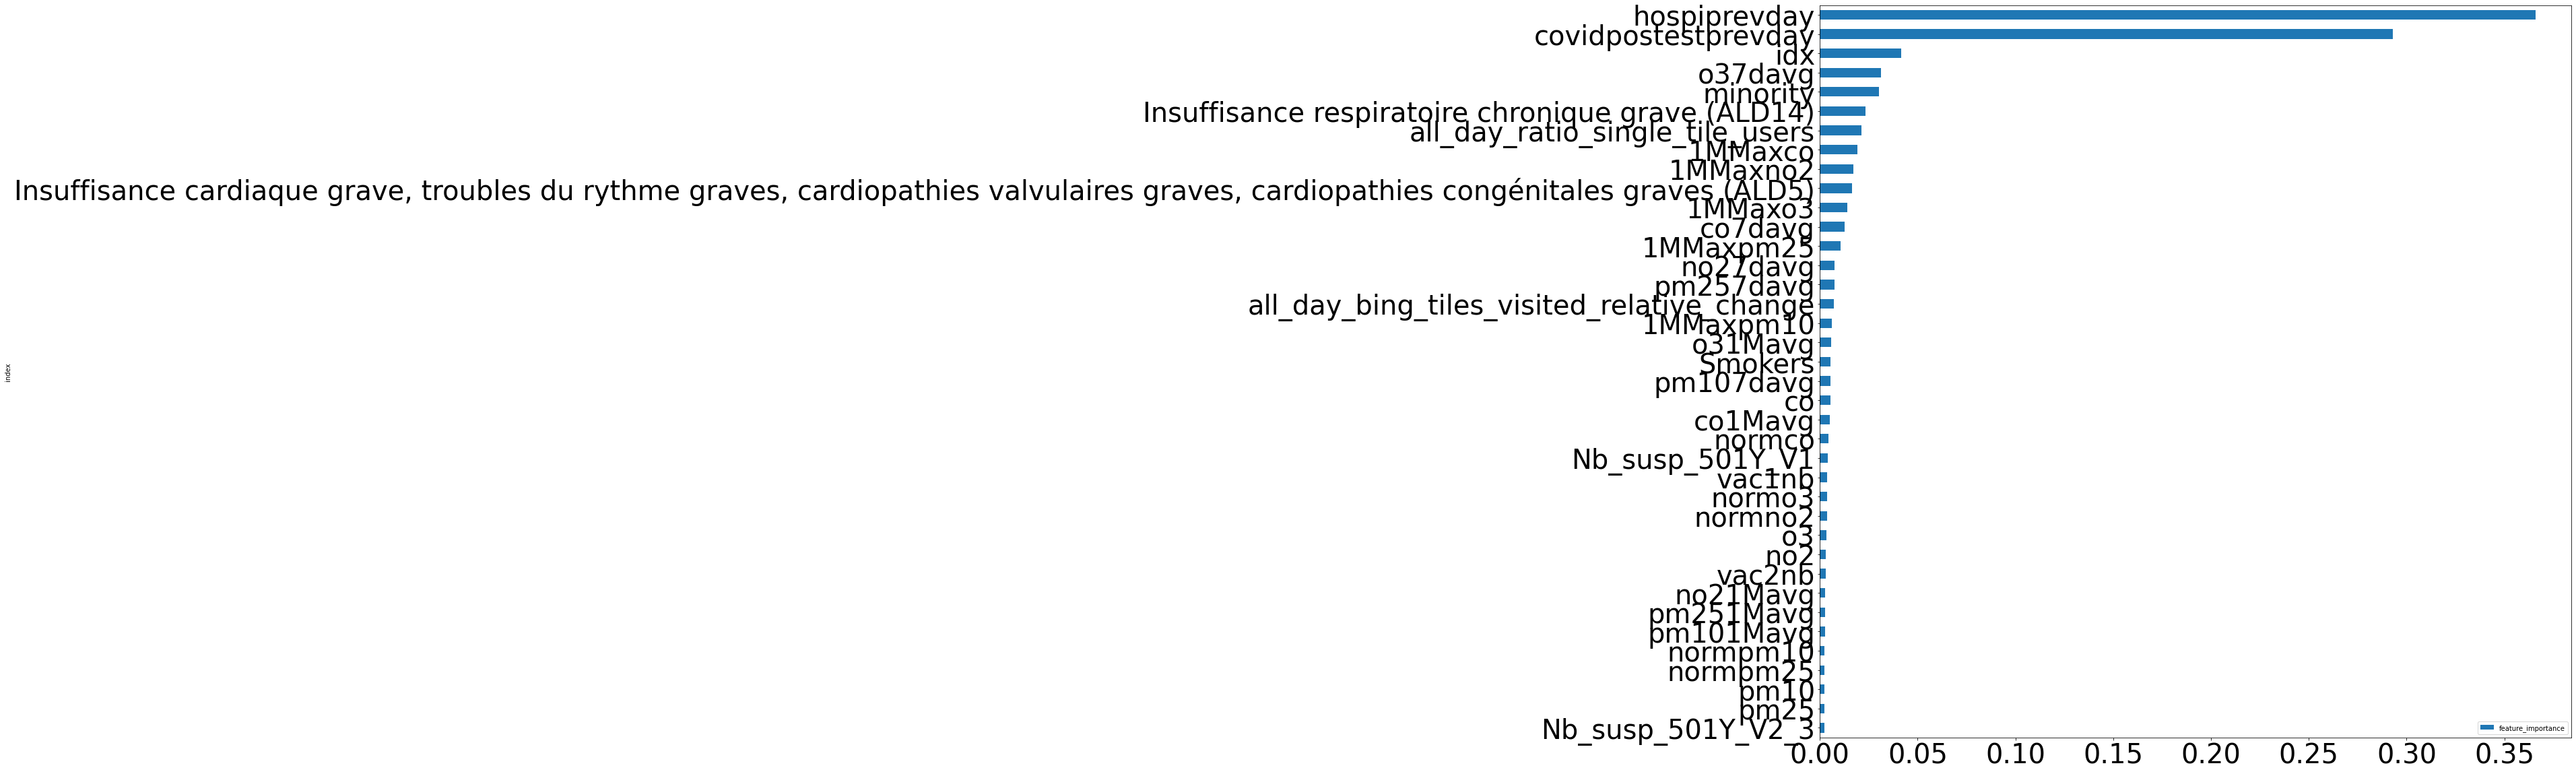

In [178]:
print("Scikit Learn - Extra Trees Regressor Feature importance report:")
FIlist = model.feature_importances_.tolist()
FIlistdf = pd.DataFrame(FIlist)
FIlistdf = FIlistdf.T
FIlistdf.columns = features
FIlistdf = FIlistdf.T.reset_index()
FIlistdf.columns = ["index","feature_importance"]
FIlistdf.sort_values(by = ["feature_importance"], inplace = True, ascending =True)
FIlistdf.to_csv("../feature_importance_Extra_Trees.csv")
print(FIlistdf)
print("\n")
fig = plt.figure(dpi = 150)
plt.rc('xtick', labelsize=40) 
plt.rc('ytick', labelsize=40) 
FIlistdf.plot.barh(x="index", y="feature_importance",figsize = (20,20))
plt.show() 

In [59]:




#Save model to .joblib file
# save the model to disk
filename = '../model/model.joblib'
joblib.dump(ensemble, filename)
 
# # some time later...
 
# # load the model from disk
# loaded_model = joblib.load(filename)
# result = loaded_model.score(X_test, Y_test)
# print(result)



print("\n")
print("TPOTRegressor")
tpot = TPOTRegressor(generations=50, population_size=50, verbosity=1, random_state=42)
tpot.fit(X_train2, y_train2)
print(tpot.score(X_test2, y_test2))
tpot.export('tpot_covid_pipeline.py')

print("\n")




TPOTRegressor


Version 0.11.6.post1 of tpot is outdated. Version 0.11.7 was released Wednesday January 06, 2021.




TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesRegressor(input_matrix, bootstrap=True, max_features=1.0, min_samples_leaf=3, min_samples_split=5, n_estimators=100)
-50.109349638278964




In [ ]:
print("Neural Network")
X_trainNN = X_train2.values.reshape(X_train2.shape[0], X_train2.shape[1], 1)
y_trainNN = y_train2.values
X_testNN = X_test2.values.reshape(X_test2.shape[0],X_test2.shape[1],1)
y_testNN = y_test2.values
NNmodel = Sequential()
#NNmodel.add(layers.Dense(215, input_shape=(X_trainNN.shape[0], X_trainNN.shape[1])))
NNmodel.add(layers.LSTM(units=22, activation='tanh',return_sequences=True, input_shape=X_trainNN.shape[1:]))
NNmodel.add(layers.LSTM(units=10, activation='tanh', return_sequences=False))
NNmodel.add(layers.Dense(1, activation="linear"))

# The compilation
NNmodel.compile(loss='mse', 
              optimizer='rmsprop')

es = callbacks.EarlyStopping(patience=30, restore_best_weights=True)

# The fit
NNmodel.fit(X_trainNN, y_trainNN,
         batch_size=16, validation_split = 0.3,
         epochs=100, verbose=1,callbacks=[es])

# The prediction
print("MSE:")
print(NNmodel.evaluate(X_testNN, y_testNN, verbose=0))

#print('validation loss (MSE):', val_loss, '\n validation MAE:', val_mae)
#print("Average error on new number of hospitalizations per day:", round(val_mae ** 0.5,0))